Importação das bibliotecas que serão usadas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import nltk

Leitura do arquivo `dados_preco.csv` para o DataFrames `data` e exibição do DataFrame

In [2]:
# Leitura do endereço do arquivo csv e criação do DataFrame 'data'
caminho = "https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv"
data = pd.read_csv(caminho)
data.head()

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0


Descrições e informações do arquivo `data`

In [3]:
print(data.describe())
print('\n --------------------------------------------- \n')
print(data.info())

        qtdInsumos     calculado       correto
count  7121.000000   7121.000000   7121.000000
mean      3.281842    137.089552    135.891798
std       3.194301    191.266516    189.806974
min       1.000000     30.000100     33.000000
25%       1.000000     49.786100     49.500000
50%       2.000000     87.350300     83.100000
75%       4.000000    165.167000    161.200000
max      26.000000  10364.992500  10356.000000

 --------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB
None


Criação do DataFrame `df` que terá informações utilizadas para Feature Engineering e treinamento do modelo, evitando também assim uma eventual modificação acidental dos dados do dataframe `data`

In [4]:
# Cria o DataFrame 'df' e copia as colunas 'descricao', 'qtdInsumos', 'calculado' e 'correto'
df = pd.DataFrame()
df = data[['descricao', 'qtdInsumos', 'calculado', 'correto']].copy()

Criação de uma coluna `qtd_cap` no `df` que representa a quantidade de capsulas de cada instância

In [5]:
# Loop para separar a string em espaços ' ' e adiciona o primeiro split à lista 'qtd_cap'
lst = []
qtd_cap = []
for descricao in df.descricao:
    lst = descricao.split(" ")
    qtd_cap.append(lst[0])

# Adiciona a lista 'qtd_cap', com o número de capsulas, à coluna 'qtd_cap' do dataframe 'df'
df["qtd_cap"] = qtd_cap
df['qtd_cap'] = pd.to_numeric(df["qtd_cap"], downcast="float")

Criação uma lista `lst_componentes` de componentes utilizados nas instâncias, separada por `;` e adiciona uma coluna `componentes` ao DataFrame `df`

In [6]:
# Loop para limpar as strings da coluna 'descricao' no DataFrame 'df'
lst_componentes=[]
for s in df['descricao']:
    
    # Remover as pontuações (exceto o caractere ';')
    s=re.sub(r'[^\w\s;]','',s)
    
    # Remover as unidades
    s=re.sub(r"(\d\w*)", "", s)
    
    # Remove os dígitos
    s=re.sub(r"(\d)", "", s)
    
    # Remove eventual conteúdo entre parênteses
    s=re.sub(r'\([^)]*\)', '', s)
    
    # Conversão para letras minúsculas
    s=s.lower()
    
    # Remove a palavra 'cap'
    s=re.sub(r"cap", "", s)
    
    # Remover espaços duplos e triplos entre as palavras
    s=re.sub(r"(\s\s\s)", " ", s)
    s=re.sub(r"(\s\s)", " ", s)
    s=re.sub(r"  ", "5htp", s)
    
    # Adiciona os componentes à lista 'lst_componentes'
    lst_componentes.append(s)
    
# Adiciona a lista 'lst_componentes' como coluna 'componentes' ao DataFrame 'df'
df['componentes'] = lst_componentes

Verificação de quantos componentes únicos existem. Isto é útil para ter uma ideia de quantas colunas serão criadas.
No caso, existem 1501 componentes únicos e, portanto, serão necessárias 1501 colunas para representar os componentes com suas variadas quantidades a depender das diferentes instâncias.

In [7]:
# Loop para verificar quantos componentes únicos existem na coluna 'componentes', do DataFrame 'df'
lst = []
componentes_unicos = set()
for words in lst_componentes:
    lst = words.split(";")
    for item in lst:
        componentes_unicos.add(item.strip())

# Imprimir o tamanho da lista de componentes
len(componentes_unicos)

1501

Criação de uma coluna `qtd` no DataFrame `df` que representa a quantidade dos componentes, separados por ';'

In [8]:
# Criando uma coluna 'qtd' que representa a quantia dos componentes, separada por ;
lst_quantidade=[]
s=[]
for s in df['descricao']:
    
    # Remove a quantidade de capsulas, removendo os primeiros 3 valores das strings na coluna 'descrição'
    sliced = s[3:]
    
    # Remove proporções
    s = re.sub(r'\d:\d\d', '', sliced)
    
    # Remove pontuações (exceto ; e .)
    s=re.sub(r'[^\d;.]','',s)
    
    # Remove eventual conteúdo entre parênteses
    s=re.sub(r'\([^)]*\)', '', s)
    
    # Adiciona as quantidades à lista 'lst_quantidade'
    lst_quantidade.append(s)

# Adiciona a lista 'lst_quantidade' como coluna 'qtd' ao DataFrame 'df'
df['qtd'] = lst_quantidade
lst_quantidade[0:5]

['150', '1', '250;150;50', '0.300', '0.250;10']

Criação de um dicionário `dict_comp_qtd` que associa a descrição (como chave) com a quantidade (como valor)

In [9]:
# Loop para separar a 'lst_componentes' por ';' e adicionar o resultado à lista 'lst_comp'
lst_comp = []
for i in lst_componentes:
    lst_comp.append(i.split(';'))
    
# Loop para separar a 'lst_quantidade' por ';' e adicionar o resultado à lista 'lst_qtd'
lst_qtd = []
for i in lst_quantidade:
    lst_qtd.append(i.split(';'))

# Criação da lista 'dict_comp_qtd' que recebe o zip duplo que associa o componente e a quantidade como um dicionário 
dict_comp_qtd = [dict(zip(*z)) for z in zip(lst_comp, lst_qtd)]

print(dict_comp_qtd)

[{' bupropiona cloridrato ': '150'}, {' finasterida ': '1'}, {' nac ': '250', ' silimarina ': '150', ' same ': '50'}, {' anastrozol ': '0.300'}, {' dutasterida ': '0.250', ' tadalafil ': '10'}, {' triiodotironina slow release ': '12'}, {' t ': '460'}, {' vitamina b ': '1260', ' acido folico ': '3', ' zinco quelado ': '30', ' selenio quelado ': '200', ' magnesio quelado ': '30400', ' picolinato de cromo ': '1000', ' saw palmeto ext seco ': '200', ' espironolactona ': '100', ' pygeum africanum ext seco ': '.100', ' finasterida ': '0.500'}, {' cortisol ': '20', ' prasterona ': '20'}, {' tadalafil ': '10', ' arginina ': '2'}, {' gestrinona ': '2'}, {' magnesio quelado ': '30200', ' coenzima q po ': '10100'}, {' silimarina ': '200', ' vitamina b ': '6100', ' acido folico ': '2.500', ' nac ': '200'}, {' vitamina d ': '10000', ' vitamina k mk ': '27100'}, {' oxandrolona ': '20'}, {' bupropiona cloridrato ': '150'}, {' triiodotironina slow release ': '10'}, {' clomifeno citrato ': '100', ' tad

Criação do dataframe `df1` a partir da lista de dicionários `dict_comp_qtd` e substituição de valores NaN por 0 (zero)

In [10]:
# Criação de 'df1'
df1 = pd.DataFrame(dict_comp_qtd)

# Transformação do tipo de dado de 'df1' para float64
df1 = df1.apply(pd.to_numeric, errors='coerce')

# Substituição de valores NaN por 0 (zero)
df1 = df1.fillna(0)

df1.head()

,bupropiona cloridrato,finasterida,nac,silimarina,same,anastrozol,dutasterida,tadalafil,triiodotironina slow release,t,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,150.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,250.0,150.0,50.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.3,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.25,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Columns: 1501 entries,  bupropiona cloridrato  to  trimetilxantina microensula 
dtypes: float64(1501)
memory usage: 81.5 MB


Criação do DataFrame `dff` que é a junção dos DataFrames `df` e `df1`

In [12]:
dff = pd.concat([df, df1], axis=1, join='inner')

dff.head()

,descricao,qtdInsumos,calculado,correto,qtd_cap,componentes,qtd,bupropiona cloridrato,finasterida,nac,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,1,47.5297,39.9,30.0,bupropiona cloridrato,150,150.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60 CAP | FINASTERIDA 1:10 1MG,1,46.9620,43.6,60.0,finasterida,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,3,105.1390,111.4,60.0,nac ; silimarina ; same,250;150;50,0.0,0.0,250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60 CAP | ANASTROZOL 1:10 0.300MG,1,49.0314,43.6,60.0,anastrozol,0.300,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2,161.8272,146.0,120.0,dutasterida ; tadalafil,0.250;10,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Descarte das colunas `descrição`, `componentes`, `calculado` e `qtd` (e `qtdInsumos`) do DataFrame para treinamento `dff`

In [13]:
dff = dff.drop(['descricao'],axis=1)
dff = dff.drop(['componentes'],axis=1)
dff = dff.drop(['calculado'],axis=1)
dff = dff.drop(['qtd'],axis=1)
# dff = dff.drop(['qtdInsumos'],axis=1)

dff = dff.apply(pd.to_numeric, errors='coerce')

In [14]:
dff.columns

Index(['qtdInsumos', 'correto', 'qtd_cap', ' bupropiona cloridrato ',
       ' finasterida ', ' nac ', ' silimarina ', ' same ', ' anastrozol ',
       ' dutasterida ',
       ...
       ' glicerina ', ' aloe vera ext glicolico ', ' pcana ',
       ' gentamicina sulfato ', ' base creme ', ' dlfenilalanina ',
       ' bacteroides fragilis ', ' andarine ', ' lprolina ',
       ' trimetilxantina microensula '],
      dtype='object', length=1504)

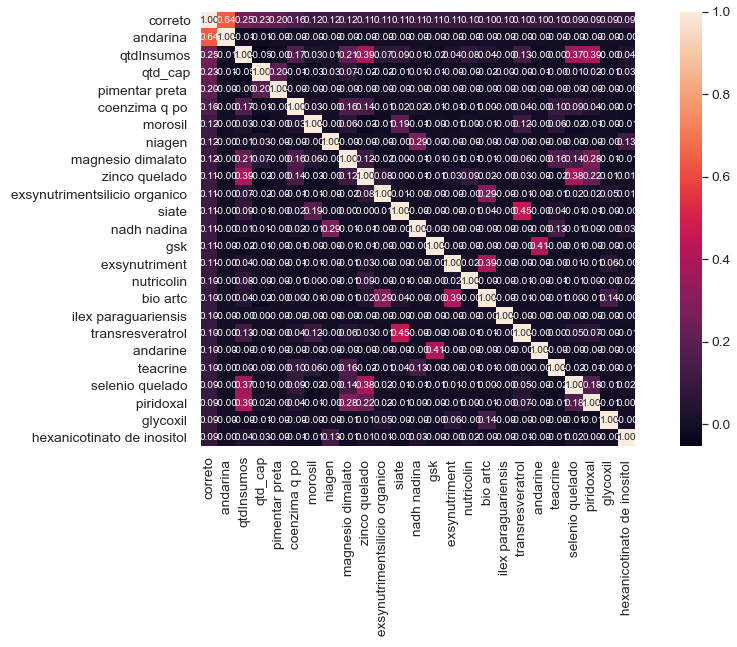

In [15]:
#saleprice correlation matrix
k = 25 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = dff.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'correto')['correto'].index
cm = np.corrcoef(dff[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Train/Test Split

In [16]:
X = dff.drop(['correto'],axis=1)
y = (dff['correto'])

# scaling = MinMaxScaler()
# scaling.fit_transform(X)
# scaling.fit_transform(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Linear Regression

In [18]:
# we are going to scale to data

# y_train= y_train.values.reshape(-1,1)
# y_test= y_test.values.reshape(-1,1)

# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.fit_transform(X_test)
# y_train = sc_X.fit_transform(y_train)
# y_test = sc_y.fit_transform(y_test)

In [19]:
X_train

,qtdInsumos,qtd_cap,bupropiona cloridrato,finasterida,nac,silimarina,same,anastrozol,dutasterida,tadalafil,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
4818,2,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,1,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6054,2,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2081,1,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3091,1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,2,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5695,11,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361,3,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1547,2,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
lm = LinearRegression()

lm.fit(X_train,y_train)
print(lm)

LinearRegression()


In [21]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

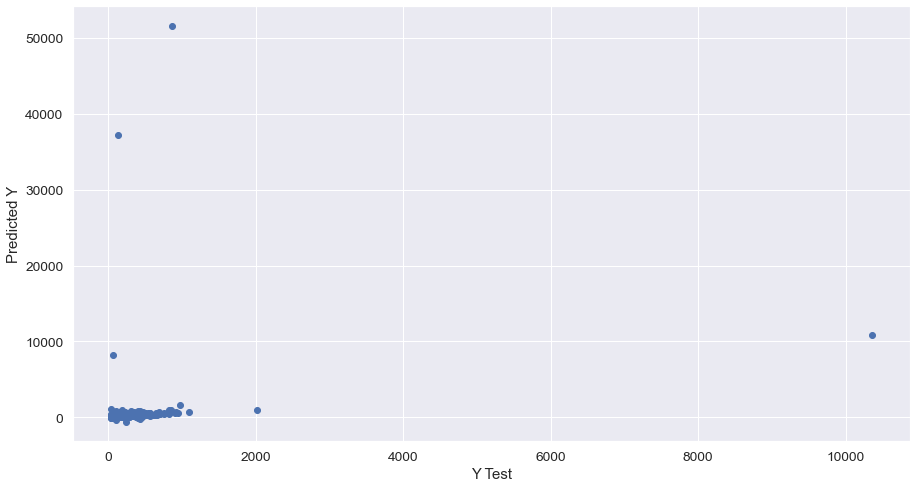

In [22]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

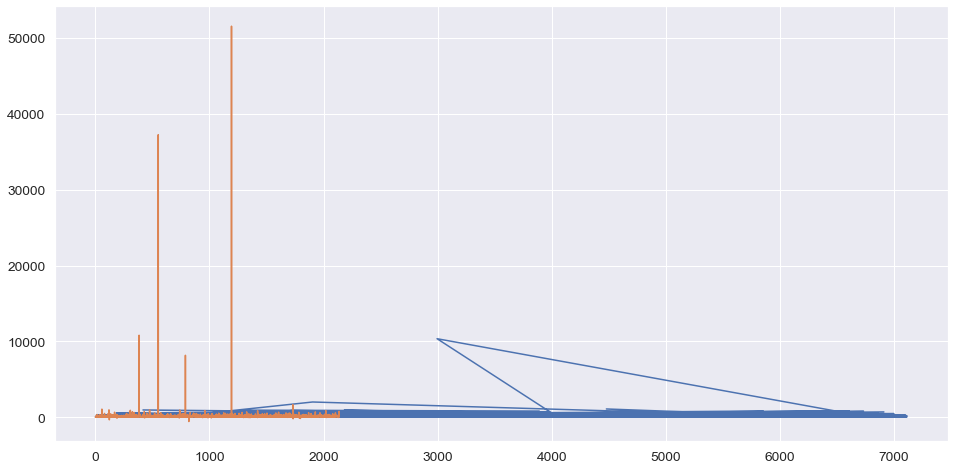

In [23]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(predictions, label = 'predict')
plt.show()

In [24]:
def r2_ajustado(y_test, predictions):
    adj_r2 = (1 - ((1 - r2_score(y_test, predictions)) * (len(y_test) - 1)) / 
    (len(y_test) - X_train.shape[1] - 1))
    return adj_r2


print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 score', r2_score(y_test, predictions))
print('R2 ajustado', r2_ajustado(y_test, predictions))

MAE: 95.99014824765474
MSE: 1887593.9947264255
RMSE: 1373.8973741609761
R2 score -27.643733538152876
R2 ajustado -95.65563165480971


# Gradien Boosting Regression

In [25]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4)

In [26]:
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)

In [27]:
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))
print('R2 score:', r2_score(y_test, clf_pred))
print('R2 ajustado', r2_ajustado(y_test, clf_pred))

MAE: 66.40097813398232
MSE: 59382.44465409602
RMSE: 243.68513424929313
R2 score: 0.09888729977520472
R2 ajustado -2.040721528720636


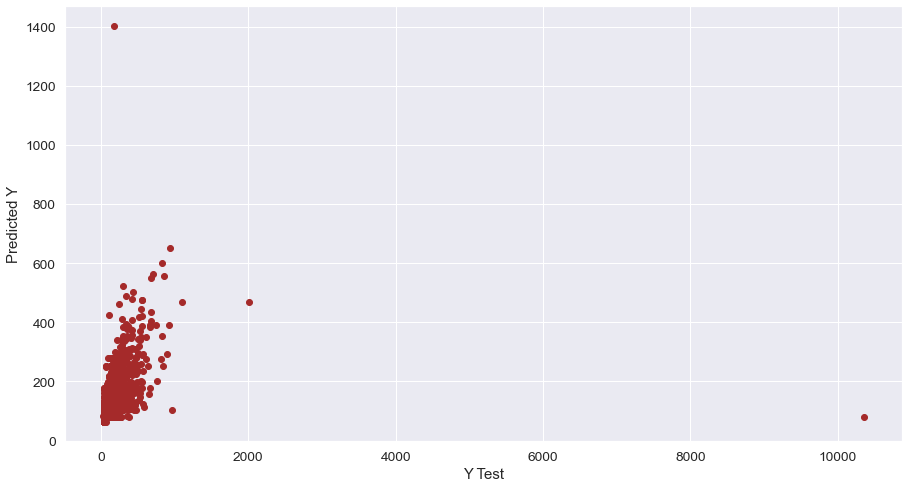

In [28]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

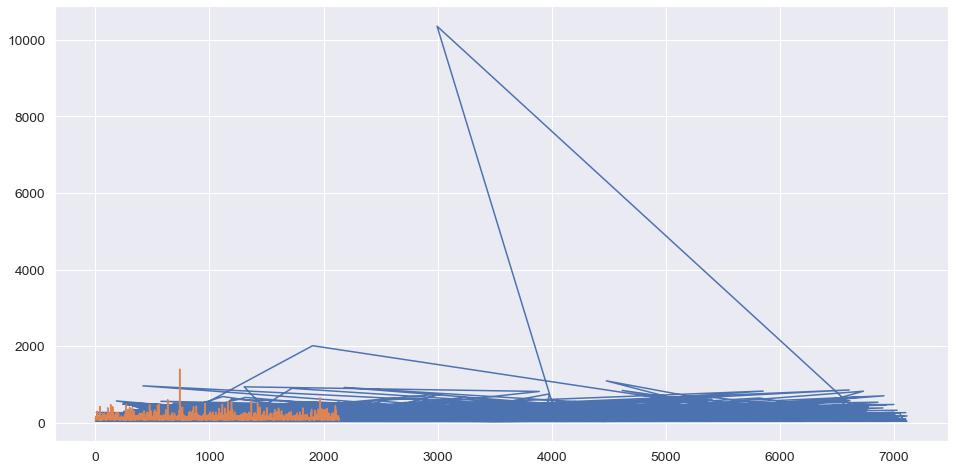

In [29]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(clf_pred, label = 'predict')
plt.show()

# Decison Tree Regression

In [30]:
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [31]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [32]:
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))
print('R2 score', r2_score(y_test, dtr_pred))
print('R2 ajustado', r2_ajustado(y_test, dtr_pred))

MAE: 55.9403197629075
MSE: 59215.843531227576
RMSE: 243.3430572899658
R2 score 0.10141542721359098
R2 ajustado -2.032190596321911


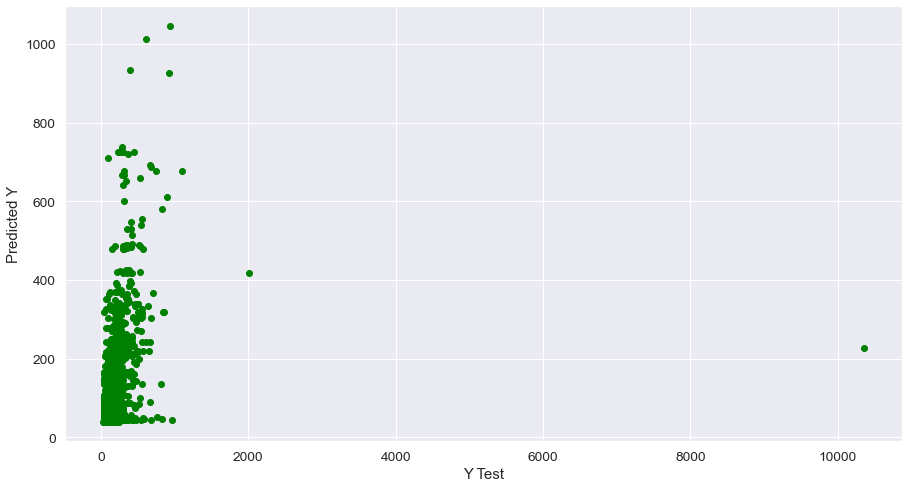

In [33]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# Support Vector Machine Regression

In [34]:
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

SVR()

In [35]:
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

In [36]:
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))
print('R2 score', r2_score(y_test, svr_pred))
print('R2 ajustado', r2_ajustado(y_test, svr_pred))

MAE: 81.83377426878717
MSE: 68481.71115053988
RMSE: 261.6901051827139
R2 score -0.03919163332425901
R2 ajustado -2.5066561276155093


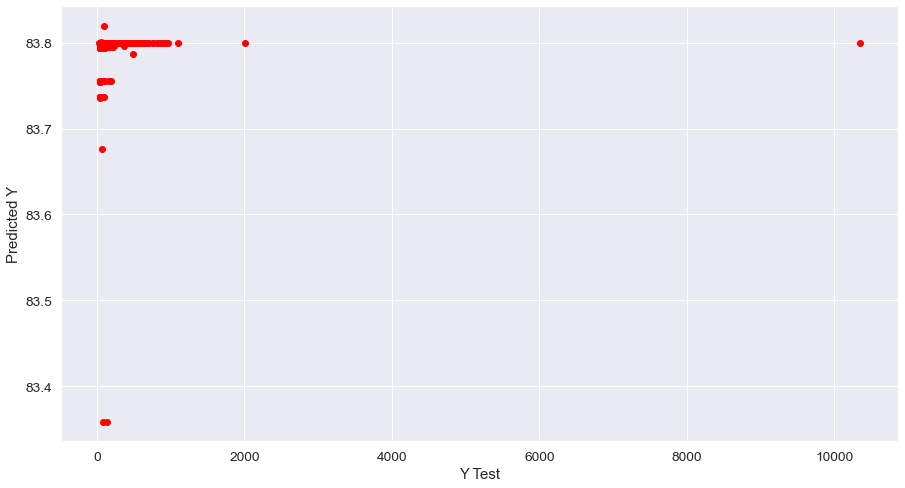

In [37]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

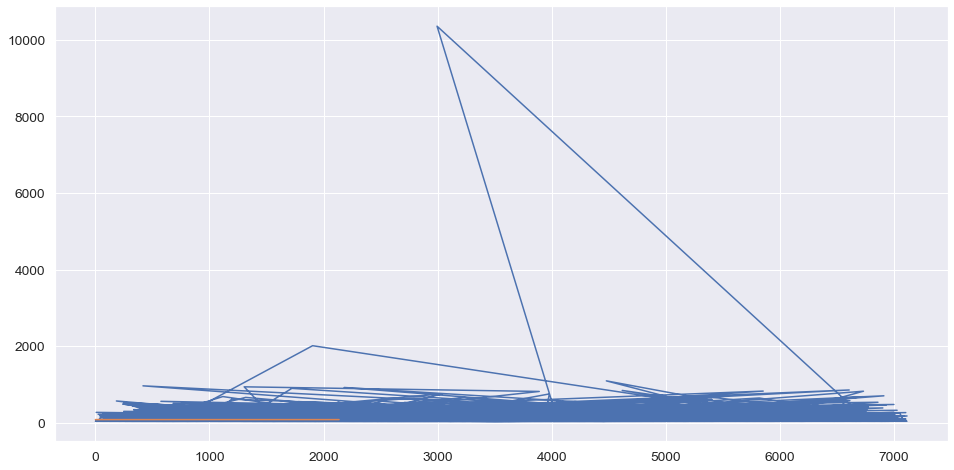

In [38]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(svr_pred, label = 'predict')
plt.show()

# Random Forest Regressor

In [39]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [40]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

In [41]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))
print('R2 score', r2_score(y_test, rfr_pred))
print('R2 ajustado', r2_ajustado(y_test, rfr_pred))

MAE: 46.07359850684464
MSE: 57016.01574650965
RMSE: 238.78026666060504
R2 score 0.13479722492608992
R2 ajustado -1.9195468049887392


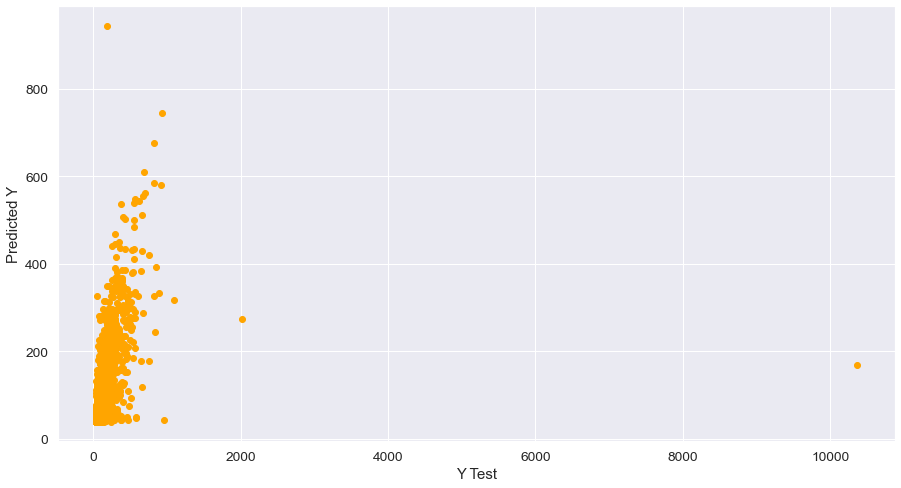

In [42]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

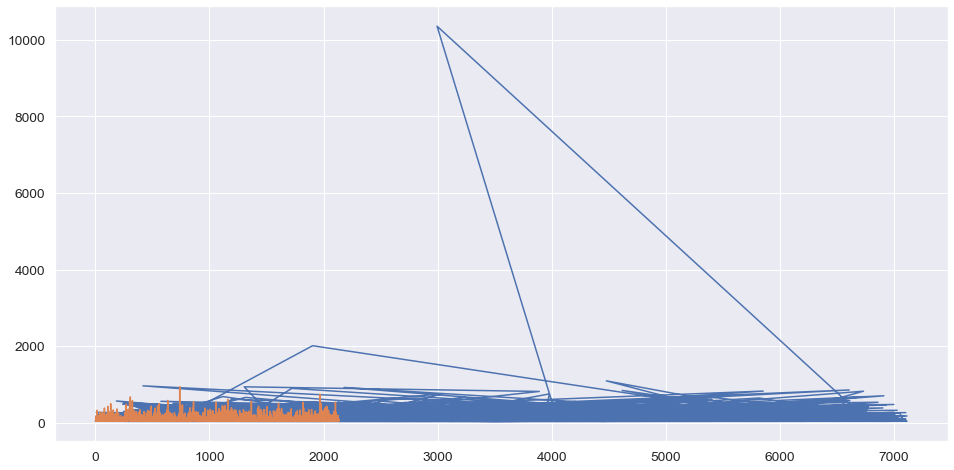

In [43]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(rfr_pred, label = 'predict')
plt.show()


# LightGBM

In [44]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [45]:
model_lgb.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9, max_bin=55,
              min_data_in_leaf=6, min_sum_hessian_in_leaf=11, n_estimators=500,
              num_leaves=5, objective='regression')

In [46]:
lgb_pred = model_lgb.predict(X_test)
lgb_pred = lgb_pred.reshape(-1,1)

In [47]:
print('MAE:', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))
print('R2 score', r2_score(y_test, lgb_pred))
print('R2 ajustado', r2_ajustado(y_test, lgb_pred))

MAE: 57.89553747659321
MSE: 57754.339052252304
RMSE: 240.3213245890849
R2 score 0.12359336641955454
R2 ajustado -1.9573531900913608


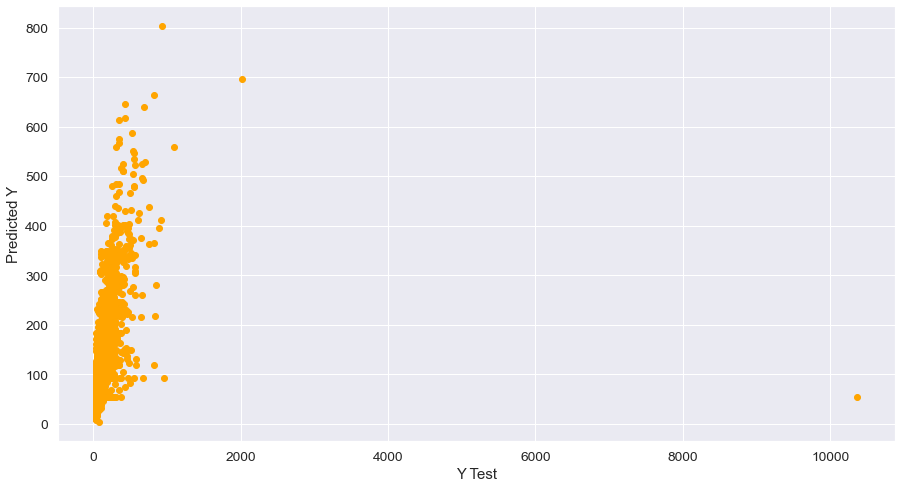

In [48]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,lgb_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

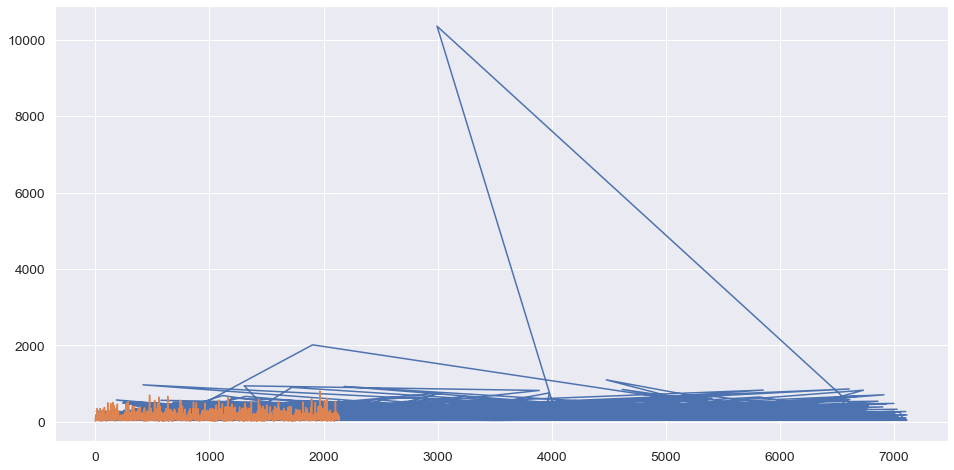

In [49]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(lgb_pred, label = 'predict')
plt.show()

# Comparação entre os modelos

In [50]:
error_rate=np.array([metrics.mean_squared_error(y_test, clf_pred), metrics.mean_squared_error(y_test, dtr_pred), metrics.mean_squared_error(y_test, svr_pred), metrics.mean_squared_error(y_test, rfr_pred), metrics.mean_squared_error(y_test, lgb_pred)])

In [51]:
a = data.copy()
data.columns

Index(['descricao', 'criado', 'qtdInsumos', 'calculado', 'correto'], dtype='object')

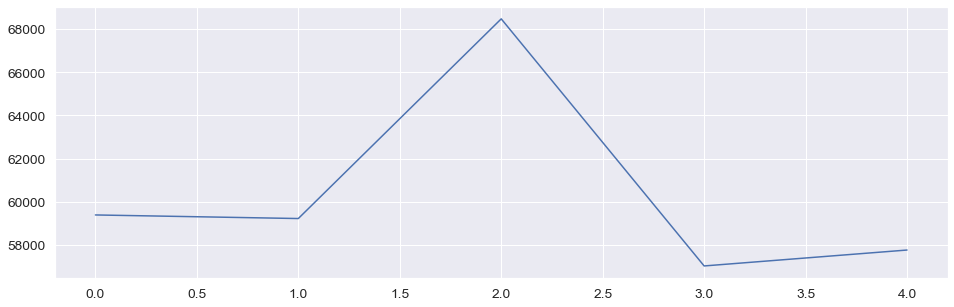

In [52]:
plt.figure(figsize=(16,5))
plt.plot(error_rate)

In [53]:
# initialise data of lists.
comp = {'MAE':[metrics.mean_absolute_error(y_test, predictions),
               metrics.mean_absolute_error(y_test, clf_pred),
               metrics.mean_absolute_error(y_test, dtr_pred), 
               metrics.mean_absolute_error(y_test, svr_pred),
               metrics.mean_absolute_error(y_test, rfr_pred),
               metrics.mean_absolute_error(y_test, lgb_pred)],
        'MSE':[metrics.mean_squared_error(y_test, predictions),
               metrics.mean_squared_error(y_test, clf_pred),
               metrics.mean_squared_error(y_test, dtr_pred),
               metrics.mean_squared_error(y_test, svr_pred),
               metrics.mean_squared_error(y_test, rfr_pred),
               metrics.mean_squared_error(y_test, lgb_pred)],
       'RMSE':[np.sqrt(metrics.mean_squared_error(y_test, predictions)),
               np.sqrt(metrics.mean_squared_error(y_test, clf_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)), 
               np.sqrt(metrics.mean_squared_error(y_test, svr_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, lgb_pred))],
   'R2 score':[r2_score(y_test, predictions),
               r2_score(y_test, clf_pred),
               r2_score(y_test, dtr_pred), 
               r2_score(y_test, svr_pred),
               r2_score(y_test, rfr_pred),
               r2_score(y_test, lgb_pred)],
'R2 ajustado':[r2_ajustado(y_test, predictions),
               r2_ajustado(y_test, clf_pred),
               r2_ajustado(y_test, dtr_pred), 
               r2_ajustado(y_test, svr_pred),
               r2_ajustado(y_test, rfr_pred),
               r2_ajustado(y_test, lgb_pred)]}
 
# Creates pandas DataFrame.
comparacao = pd.DataFrame(comp, index =['Regressão Linear',
                                'Gradient Boost',
                                'Decision Tree',
                                'Support Vector Machine',
                                'Random Forest',
                                'LightGBM'])
comparacao

,MAE,MSE,RMSE,R2 score,R2 ajustado
Regressão Linear,95.990148,1.887594e+06,1373.897374,-27.643734,-95.655632
Gradient Boost,66.400978,5.938244e+04,243.685134,0.098887,-2.040722
Decision Tree,55.940320,5.921584e+04,243.343057,0.101415,-2.032191
Support Vector Machine,81.833774,6.848171e+04,261.690105,-0.039192,-2.506656
Random Forest,46.073599,5.701602e+04,238.780267,0.134797,-1.919547
LightGBM,57.895537,5.775434e+04,240.321325,0.123593,-1.957353


In [54]:
test_prediction_rl = pd.DataFrame(predictions, columns=['calculado_RL'])
test_prediction_clf = pd.DataFrame(clf_pred, columns=['calculado_Gradient Boost'])
test_prediction_dtr = pd.DataFrame(dtr_pred, columns=['calculado_Decision Tree'])
test_prediction_svr = pd.DataFrame(svr_pred, columns=['calculado_SVM'])
test_prediction_rfr = pd.DataFrame(rfr_pred, columns=['calculado_Random Forest'])
test_prediction_lgb = pd.DataFrame(lgb_pred, columns=['calculado_LightGBM'])

In [55]:
# Backup com standization e log

# test_prediction_svr =sc_y.inverse_transform(svr_pred)

# test_prediction_svr = pd.DataFrame(test_prediction_svr, columns=['calculado_ivan'])
# test_prediction_svr['calculado_ivan'] = np.exp(test_prediction_svr['calculado_ivan'])


In [56]:
result = pd.concat([a,test_prediction_rl,test_prediction_clf,test_prediction_dtr,test_prediction_svr,test_prediction_rfr,test_prediction_lgb], axis=1)
result = result.drop(['criado'],axis=1)
result = result.drop(['qtdInsumos'],axis=1)

In [57]:
result.head(10)

,descricao,calculado,correto,calculado_RL,calculado_Gradient Boost,calculado_Decision Tree,calculado_SVM,calculado_Random Forest,calculado_LightGBM
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,47.5297,39.9,11.742795,68.759720,39.9,83.736939,40.1930,14.479641
1,60 CAP | FINASTERIDA 1:10 1MG,46.9620,43.6,78.099270,103.886610,55.2,83.800002,63.0870,107.777310
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,105.1390,111.4,102.745653,124.298718,49.5,83.800002,49.5950,130.035475
3,60 CAP | ANASTROZOL 1:10 0.300MG,49.0314,43.6,24.040748,80.208739,39.9,83.800001,41.3650,41.076016
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,161.8272,146.0,65.575257,171.083891,85.0,83.800002,97.4155,178.155907
5,240 CAP | TRIIODOTIRONINA SLOW RELEASE 12MCG,40.6362,77.0,31.691008,91.005540,44.0,83.800002,44.1540,45.448075
6,120 CAP | T4 60MCG,35.1005,50.0,165.189451,119.597010,139.0,83.800002,181.9000,150.921966
7,60 CAP | VITAMINA B2 30MG; VITAMINA B3 60MG;...,248.2063,272.2,66.472224,106.764741,61.4,83.800002,61.3380,81.056423
8,60 CAP | CORTISOL 20MG; PRASTERONA 20MG,220.1472,206.6,121.286220,103.886610,69.0,83.800002,106.6900,93.477774
9,30 CAP | TADALAFIL 10MG; ARGININA 2G,134.5175,127.4,79.879621,134.383481,72.0,83.800002,114.0710,183.513169
